In [3]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyPDMP.models import VAE
from pyPDMP.utils import loss_function
import pyPDMP.utils as utils
from pyPDMP.utils import HDSint

## Define Variables and parameters of the PDMP Model
ODE:
$$\begin{bmatrix}\dot{x}\\ \dot{v}\end{bmatrix} = \begin{bmatrix}v\\ -kx - bv\end{bmatrix}$$

In [4]:
k = 2                            # Spring Stiffness
b = 2                            # Damping coeff.
x0 = [5,0]                       # Initial Condition
t = np.linspace(0,10,1000)       # flow time span
Sigma = np.array([[5,0],[0,5]])  # Cov. of jump space dist. (Normal)
mu = np.array([0,0])             # Mean of jump space dist. (Normal)
tau = 0.4                        # Time constant of time jump space dist. (Cumulative Exp.)

# ODE of the flows
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

## Generate Data

In [5]:
# Integrate Hybrid System
Ttot, Xtot, Xevent, Xreset, C = HDSint(5000,t,fun,x0,mu,Sigma,tau)

Progress:
25.0
50.0
75.0
100.0


Text(0.5, 0, 't')

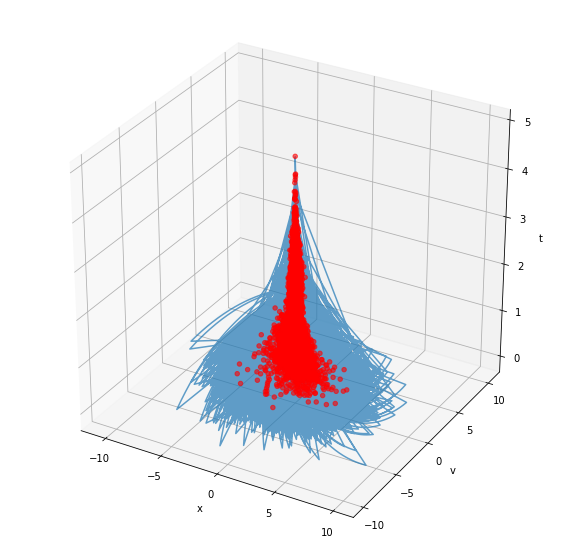

In [6]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot(xs = Xtot[:,0], ys = Xtot[:,1],zs = Xtot[:,2],alpha = 0.7)
ax.scatter(xs = Xevent[:,0], ys = Xevent[:,1],zs = Xevent[:,2],alpha = .6,color = 'red')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('t')

### Create and load dataset

In [267]:
# Create Labels - NOT NEEDED FOR VAE
y = torch.tensor([1 for i in range(Xevent.shape[0])])

X = torch.tensor(Xevent).float()

print(X.shape,y.shape)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

torch.Size([5000, 3]) torch.Size([5000])


## Training the VAE

In [268]:
import torch.nn as nn

class SmallVAE(nn.Module):
    def __init__(self,
                 i=784,
                 lec=400,
                 lds=20,
                 ldec=400,
                 out=784,
                 ):
        '''
        :param in: input shape
        :param lec: latent vector size - encoding layer
        :param lds: latent distribution size (dimension of vectors mu, logvar)
        :param ldec: latent vector sizes - decoding layers
        0: Do not normalize, 1: Batch normalization, 2: Layer normalization
        :param out: output shape
        '''
        super(SmallVAE, self).__init__()
        # input size
        self.i = i

        self.fc1 = nn.Linear(i, lec)
        self.fc21 = nn.Linear(lec, lds)
        self.fc22 = nn.Linear(lec, lds)

        self.fc3 = nn.Linear(lds, ldec)
        self.fc4 = nn.Linear(ldec, out)

    def encode(self, x):
        # encodes data x into mu, logvar
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.i))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [269]:
m = SmallVAE(i=3, lec=240, lds=120, ldec=240, out=3)
m

SmallVAE(
  (fc1): Linear(in_features=3, out_features=240, bias=True)
  (fc21): Linear(in_features=240, out_features=120, bias=True)
  (fc22): Linear(in_features=240, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=240, bias=True)
  (fc4): Linear(in_features=240, out_features=3, bias=True)
)

In [270]:
X = 2*(X - X.min(0)[0])/(X.max(0)[0] - X.min(0)[0]) - 1

In [271]:
dataset = torch.utils.data.TensorDataset(X,y)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=512, 
                                          shuffle=True)

In [272]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_functionzz(recon_x, x, mu, logvar, size, r):
    if r >= 1000: r = 1000
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, size), reduction='sum')
    loss = F.mse_loss(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = 0.01*(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    loss += KLD
    return loss

In [273]:
size = 3

def train(m, loader, epochs):
    m.train()
    optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (x, _) in enumerate(loader):
            # flatten the batch
            x = x.view(-1, size)
            optimizer.zero_grad()
            recon_batch, mu, logvar = m(x)
            loss = loss_functionzz(recon_batch, x, mu, logvar, size, epoch)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(x), len(loader.dataset),
                    100. * batch_idx / len(loader),
                    loss.item() / len(x)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(loader.dataset)))

In [274]:
train(m, data_loader, 100)

Train Epoch: 0 [0/5000 (0%)]	Loss: 0.445033
====> Epoch: 0 Average loss: 0.2638
Train Epoch: 1 [0/5000 (0%)]	Loss: 0.187538
====> Epoch: 1 Average loss: 0.1571
Train Epoch: 2 [0/5000 (0%)]	Loss: 0.126601
====> Epoch: 2 Average loss: 0.1208
Train Epoch: 3 [0/5000 (0%)]	Loss: 0.111101
====> Epoch: 3 Average loss: 0.1103
Train Epoch: 4 [0/5000 (0%)]	Loss: 0.103664
====> Epoch: 4 Average loss: 0.1030
Train Epoch: 5 [0/5000 (0%)]	Loss: 0.100275
====> Epoch: 5 Average loss: 0.1003
Train Epoch: 6 [0/5000 (0%)]	Loss: 0.097779
====> Epoch: 6 Average loss: 0.0978
Train Epoch: 7 [0/5000 (0%)]	Loss: 0.098296
====> Epoch: 7 Average loss: 0.0973
Train Epoch: 8 [0/5000 (0%)]	Loss: 0.097269
====> Epoch: 8 Average loss: 0.0954
Train Epoch: 9 [0/5000 (0%)]	Loss: 0.099419
====> Epoch: 9 Average loss: 0.0941
Train Epoch: 10 [0/5000 (0%)]	Loss: 0.092946
====> Epoch: 10 Average loss: 0.0930
Train Epoch: 11 [0/5000 (0%)]	Loss: 0.093424
====> Epoch: 11 Average loss: 0.0926
Train Epoch: 12 [0/5000 (0%)]	Loss: 

In [275]:
x = data_loader.dataset.tensors[0]
y = m(x.float().view(-1,size))[0].detach().numpy()

Text(0.5, 0, 't')

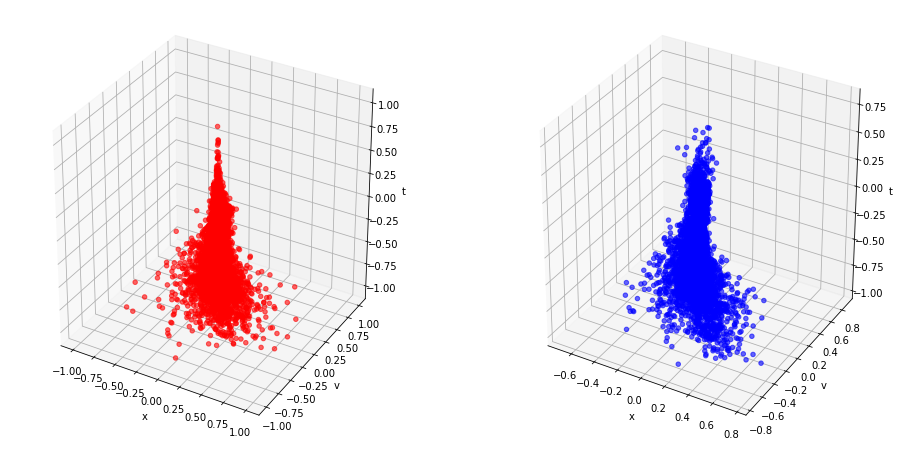

In [276]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(xs = X[:,0], ys = X[:,1],zs = X[:,2],alpha = .6,color = 'red')
ax1.set_xlabel('x')
ax1.set_ylabel('v')
ax1.set_zlabel('t')
#
ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter(xs = y[:,0], ys = y[:,1],zs = y[:,2],alpha = .6,color = 'blue')
ax2.set_xlabel('x')
ax2.set_ylabel('v')
ax2.set_zlabel('t')

In [288]:
x = data_loader.dataset.tensors[0]
mu, logvar = m.encode(x.float().view(-1,size))
mu, logvar = mu, logvar
z = m.reparameterize(mu, logvar).detach().numpy()

Text(0.5, 0, 't')

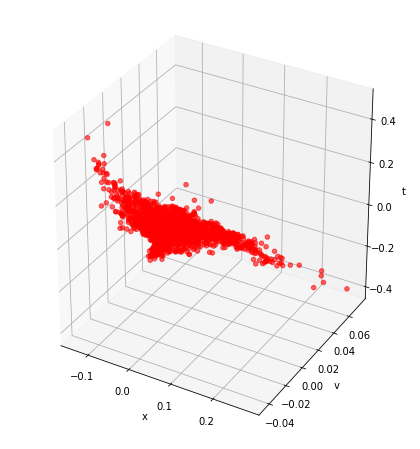

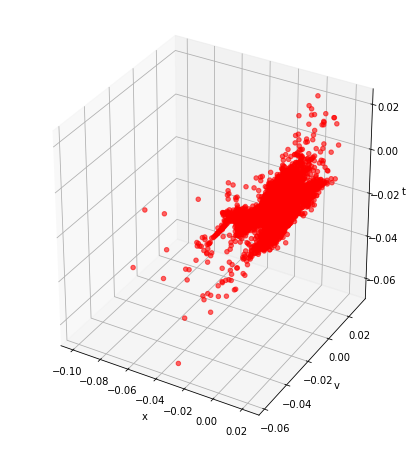

In [284]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(xs = mu[:,0], ys = mu[:,1],zs = mu[:,2],alpha = .6,color = 'red')
ax1.set_xlabel('x')
ax1.set_ylabel('v')
ax1.set_zlabel('t')
#
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(122,projection='3d')
ax1.scatter(xs = var[:,0], ys = var[:,1],zs = var[:,2],alpha = .6,color = 'red')
ax1.set_xlabel('x')
ax1.set_ylabel('v')
ax1.set_zlabel('t')

Text(0.5, 0, 't')

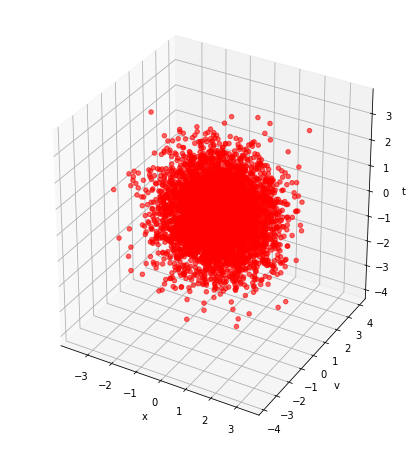

In [289]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(xs = z[:,0], ys = z[:,1],zs = z[:,2],alpha = .6,color = 'red')
ax1.set_xlabel('x')
ax1.set_ylabel('v')
ax1.set_zlabel('t')